# Preprocessing terms

1. Scaling to the right size
2. Increase contrast
3. Binarize image
4. remove noise and scanning artefacts (black border)
5. Deskew
6. Remove border

In [39]:
import re
import cv2
import glob
import imutils
import tempfile
import dateparser
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract as pt
from datefinder import find_dates
from dateutil.parser import parse
from matplotlib import pyplot as plt
from dateparser.search import search_dates
from imutils.perspective import four_point_transform
pt.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [28]:
# import the necessary packages
from PIL import Image
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

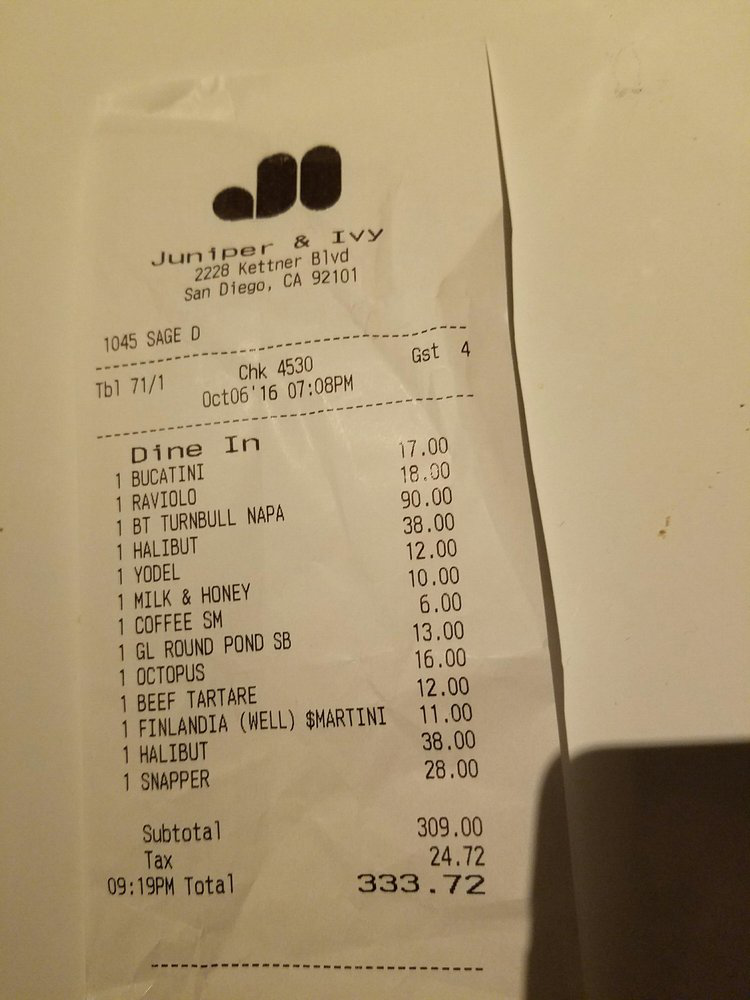

In [29]:
Image.open("images/4.jpeg")

In [30]:
image = cv2.imread("images/4.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

In [31]:

# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None
 
# ensure that at least one contour was found
if len(cnts) > 0:
 # sort the contours according to their size in
# descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
    # loop over the sorted contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # if our approximated contour has four points,
    # then we can assume we have found the paper
    if len(approx) == 4:
        docCnt = approx
        break

In [32]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

In [33]:
thresh = cv2.threshold(warped, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [35]:
Image.fromarray(thresh)

In [134]:
pattern1 = r"(\d{1,4}([.'’\-/])\d{1,2}([.'’\-/])\d{1,4})"
pattern2 = r"(\d{1,4}([.'’\-/\s])[ADFJMNOSadfjmnos]\w*([.'’\-/\s]*)\d{1,4})"
pattern3 = r"([ADFJMNOSadfjmnos]\w*\s\d{1,4}([,'’.\-/\s]*)([.'’\-/\s])\d{1,4})"
pattern4 = r"[ADFJMNOSadfjmnos]\w*\d{1,4}(['’]*)\d{1,4}"
pattern5 = r"(\d{1,4}([.'’\-/\s])\d{1,4}"

In [131]:
def finding_date(img_str):
    newstr = list(set(map(lambda x : x.strip(), img_str.split('\n'))))
    tags = []
    for i in newstr:
        try:
            find_date = search_dates(i) 
        except:
            continue
        if find_date:
            for j in find_date:
                tags.append(j[0])

    pattern1 = r"(\d{1,4}([.'’\-/])\d{1,2}([.'’\-/])\d{1,4})"
    pattern2 = r"(\d{1,4}([.'’\-/\s])[ADFJMNOSadfjmnos]\w*([.'’\-/\s]*)\d{1,4})"
    pattern3 = r"([ADFJMNOSadfjmnos]\w*\s\d{1,4}([,'’.\-/\s]*)([.'’\-/\s])\d{1,4})"
    pattern4 = r"[ADFJMNOSadfjmnos]\w*\d{1,4}(['’]*)\d{1,4}"
    pattern5 = r"(\d{1,4}([.'’\-/\s])\d{1,4}"
    
    date_find = []

    for i in tags:
        for j in (re.search(regex,i) for regex in [pattern1, pattern2, pattern3, pattern4]):
            if j:
                s = j.group()
                if s.find('.'):
                    date_find.append("-".join(s.split('.')))
                else:
                    date_find.append(s)

    date_find = list(set(date_find))

    dates = {}
    for i in date_find:
        try:
            dates[i] = search_dates(i)[0][1].strftime("%Y-%m-%d")
        except:
            continue
    print(dates)
    if dates:
        #print(min(dates.values()))
        return min(dates.values())
    return None

In [133]:
finding_date(pt.image_to_string(Image.fromarray(img_thres)))

{}


# Instead of feeding single input image with pre-process.
# Now, I'm going to feed more than 4 same image with differently pre-processed.Also called Stacking technique

In [118]:
def globalpreprocess(path):
    
    img_str_1 = pt.image_to_string(path, lang='eng')
    
    gaussian_filter = (5,5)
    img = cv2.imread(path) 
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, gaussian_filter, 0)
    img_str_2 = pt.image_to_string(Image.fromarray(img_blur),lang ="eng")
    
    kernel = np.ones((1, 1), np.uint8)
    img_dilate = cv2.dilate(img_gray, kernel, iterations=1)
    img_erode = cv2.erode(img_dilate, kernel, iterations=1)
    img_gauss = cv2.GaussianBlur(img_erode, gaussian_filter, 0)
    img_ad_thres = cv2.adaptiveThreshold(img_gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    img_str_3 = pt.image_to_string(Image.fromarray(img_ad_thres),lang='eng')

    ret,th1 = cv2.threshold(img_gauss, 100, 225, cv2.THRESH_BINARY)
    img_str_4 = pt.image_to_string(Image.fromarray(th1), lang = 'eng')

    return [img_str_1,img_str_2,img_str_3,img_str_4]

In [119]:
l = globalpreprocess(path)

In [128]:
# 1. Without any filter
path = "images/68.jpeg"
print(pt.image_to_string(path, lang='eng'))

RINCON MEXICANO
‘99 BROADWAY
SOMERVILLE, MA 02145
6179661387

ORDER: 45

Dine In
Cashier: LORENZO REYES
09-May-2017 7:19:46P
—_—

   
       

2 Arroz $3.00
2 Taco De Pescado $7.00
2 Taco Tuesday Pollo $2.00
1 Taco D Carne Asada $2.99
S Taco D Chorizo $2.99
1 Taco Tuesday Pastor $1.00
1 Horchata $2.99
1 Taco Tuesday Pollo $1.00
1 Taco D Cochinita $2.99
1 Taco D Carnitas $2.99
Subtotal
Tax $2.03
Total a

Order 7JTOG77X6ANR8

ssa G0, SS


In [129]:
# 2. with filter
# image < resize < grayscale < gaussian 
gaussian_filter = (5,5)
img = cv2.imread(path) 
image = cv2.resize(img, None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, gaussian_filter, 0)

print(pt.image_to_string(Image.fromarray(blurred)))

RINCON MEXICANO
99 BROADWAY
SOMERVILLE, MA 02145
6179661 387

ORDER: 45

Dine In
Cashier: LORENZO RE YES
09-May-2017 7:19 46P
2 ——

       
   

  
      
    
 
 
  

  

2 Arroz $3.00
9 Taco De Pescado $7.00
2 Taco Tuesday Pollo $2.00
1 Taco D Carne Asada $2.99
1 Taco D Chorizo $2.99
1 Taco Tuesday Pastor $1.00
1 Horchata $2.99
1 Taco Tuesday Pollo $1.00
1 Taco D Cochinita $2.99
1 Taco D Carnitas $2.99
Subtotal $28.95
Tall $2.03
Total $20.98

Order 7JTOG77X6ANR8


In [130]:
# 3. with filter
# image < resize < grayscale < gaussian < Binarization(auto)
gaussian_filter = (5,5)
img = cv2.imread(path) 
img = cv2.resize(img, None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel = np.ones((1, 1), np.uint8)
img_dilate = cv2.dilate(img_grayscale, kernel, iterations=1)
img_erode = cv2.erode(img_dilate, kernel, iterations=1)
img_gauss = cv2.GaussianBlur(img_erode, gaussian_filter, 0)

# Thresholding
img_thres = cv2.adaptiveThreshold(img_gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

print(pt.image_to_string(Image.fromarray(img_thres),lang='eng'))

_ RINCON MEXICANO
- 99 BROADWAY

. SOMERVILLE, MA 02146 °
6179661387. -

.. ORDER: 45 -

Dine In’

- Cashier: LORENZO REYES |
_03- -May-2017 7: 19: 4GP
ee

“2: "Artoz 2.0
“2%. Taco De Pescado | .
: 2.7 Taco Tuesday Pollo
1: Taco D Carne Asada_.-... -
: Vs ‘Taco D Chorizo ... ." -
-Taco Tuesday Pastor
“Horchata = a3
~. Taco Tuesday Pollo”.
7 Taco D Cochinita ;:

Taco D Carnitas -

wae

“onder TATOGTZXGANRB - as

mai ee Sane weer

nee Rew mee cere


In [104]:
# 4. with filters
# image < resize < grayscale < gaussian < Binarization(threshold)
ret,th1 = cv2.threshold(img_gauss,100,225,cv2.THRESH_BINARY)
ret2,th2 = cv2.threshold(img_gauss,100,220,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(pt.image_to_string(Image.fromarray(th1), lang = 'eng'))

# adaptive threshold doesnt works
# also OTSU doesnt works

BOUDIN BAKERIES
SFO International Termina|
SAN FRANCISCO, CA 94128
www. boudinbakery .com

44433 San A

hk 3003 033 Gst 0
Jund1'19 11:10AM

TO GO

1 TC BRAISED CHK 2 12.89

1 CAFE LATTE 4,15

Ice

CASH 20.00
Subtota] 17.04
Tax 1.16
2% Surcharge 0.34
Payment 18.54
Change Due 1.46

#Restaurant Employee
Benefits Surcharge
KESAAAKKAERAAKEERAA AREER RAR ERE

FECES OE ake
RARERERRE REE REE AE EERE EERE EEE
FSSC


In [126]:
#Image.fromarray(ret2)


100.0

In [75]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew


In [84]:
img = cv2.imread(path) 
image = cv2.resize(img, None, fx = 2, fy = 2, interpolation=cv2.INTER_CUBIC) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, gaussian_filter, 0)

# creating copy of original image
orig = image.copy()

# convert to grayscale and blur to smooth
#blurred = cv2.medianBlur(gray, 5)

# apply Canny Edge Detection
edged = cv2.Canny(blurred, 0, 50)
orig_edged = edged.copy()

# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
(contours, _) = cv2.findContours(img_thres2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

#x,y,w,h = cv2.boundingRect(contours[0])
#cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),0)

# get approximate contour
for c in contours:
    p = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * p, True)

    if len(approx) == 4:
        target = approx
        break


# mapping target points to 800x800 quadrilateral
approx = rectify(target)
pts2 = np.float32([[0,0],[800,0],[800,800],[0,800]])

M = cv2.getPerspectiveTransform(approx,pts2)
dst = cv2.warpPerspective(orig,M,(800,800))
dst = cv2.drawContours(image, [target], -1, (0, 255, 0), 2)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

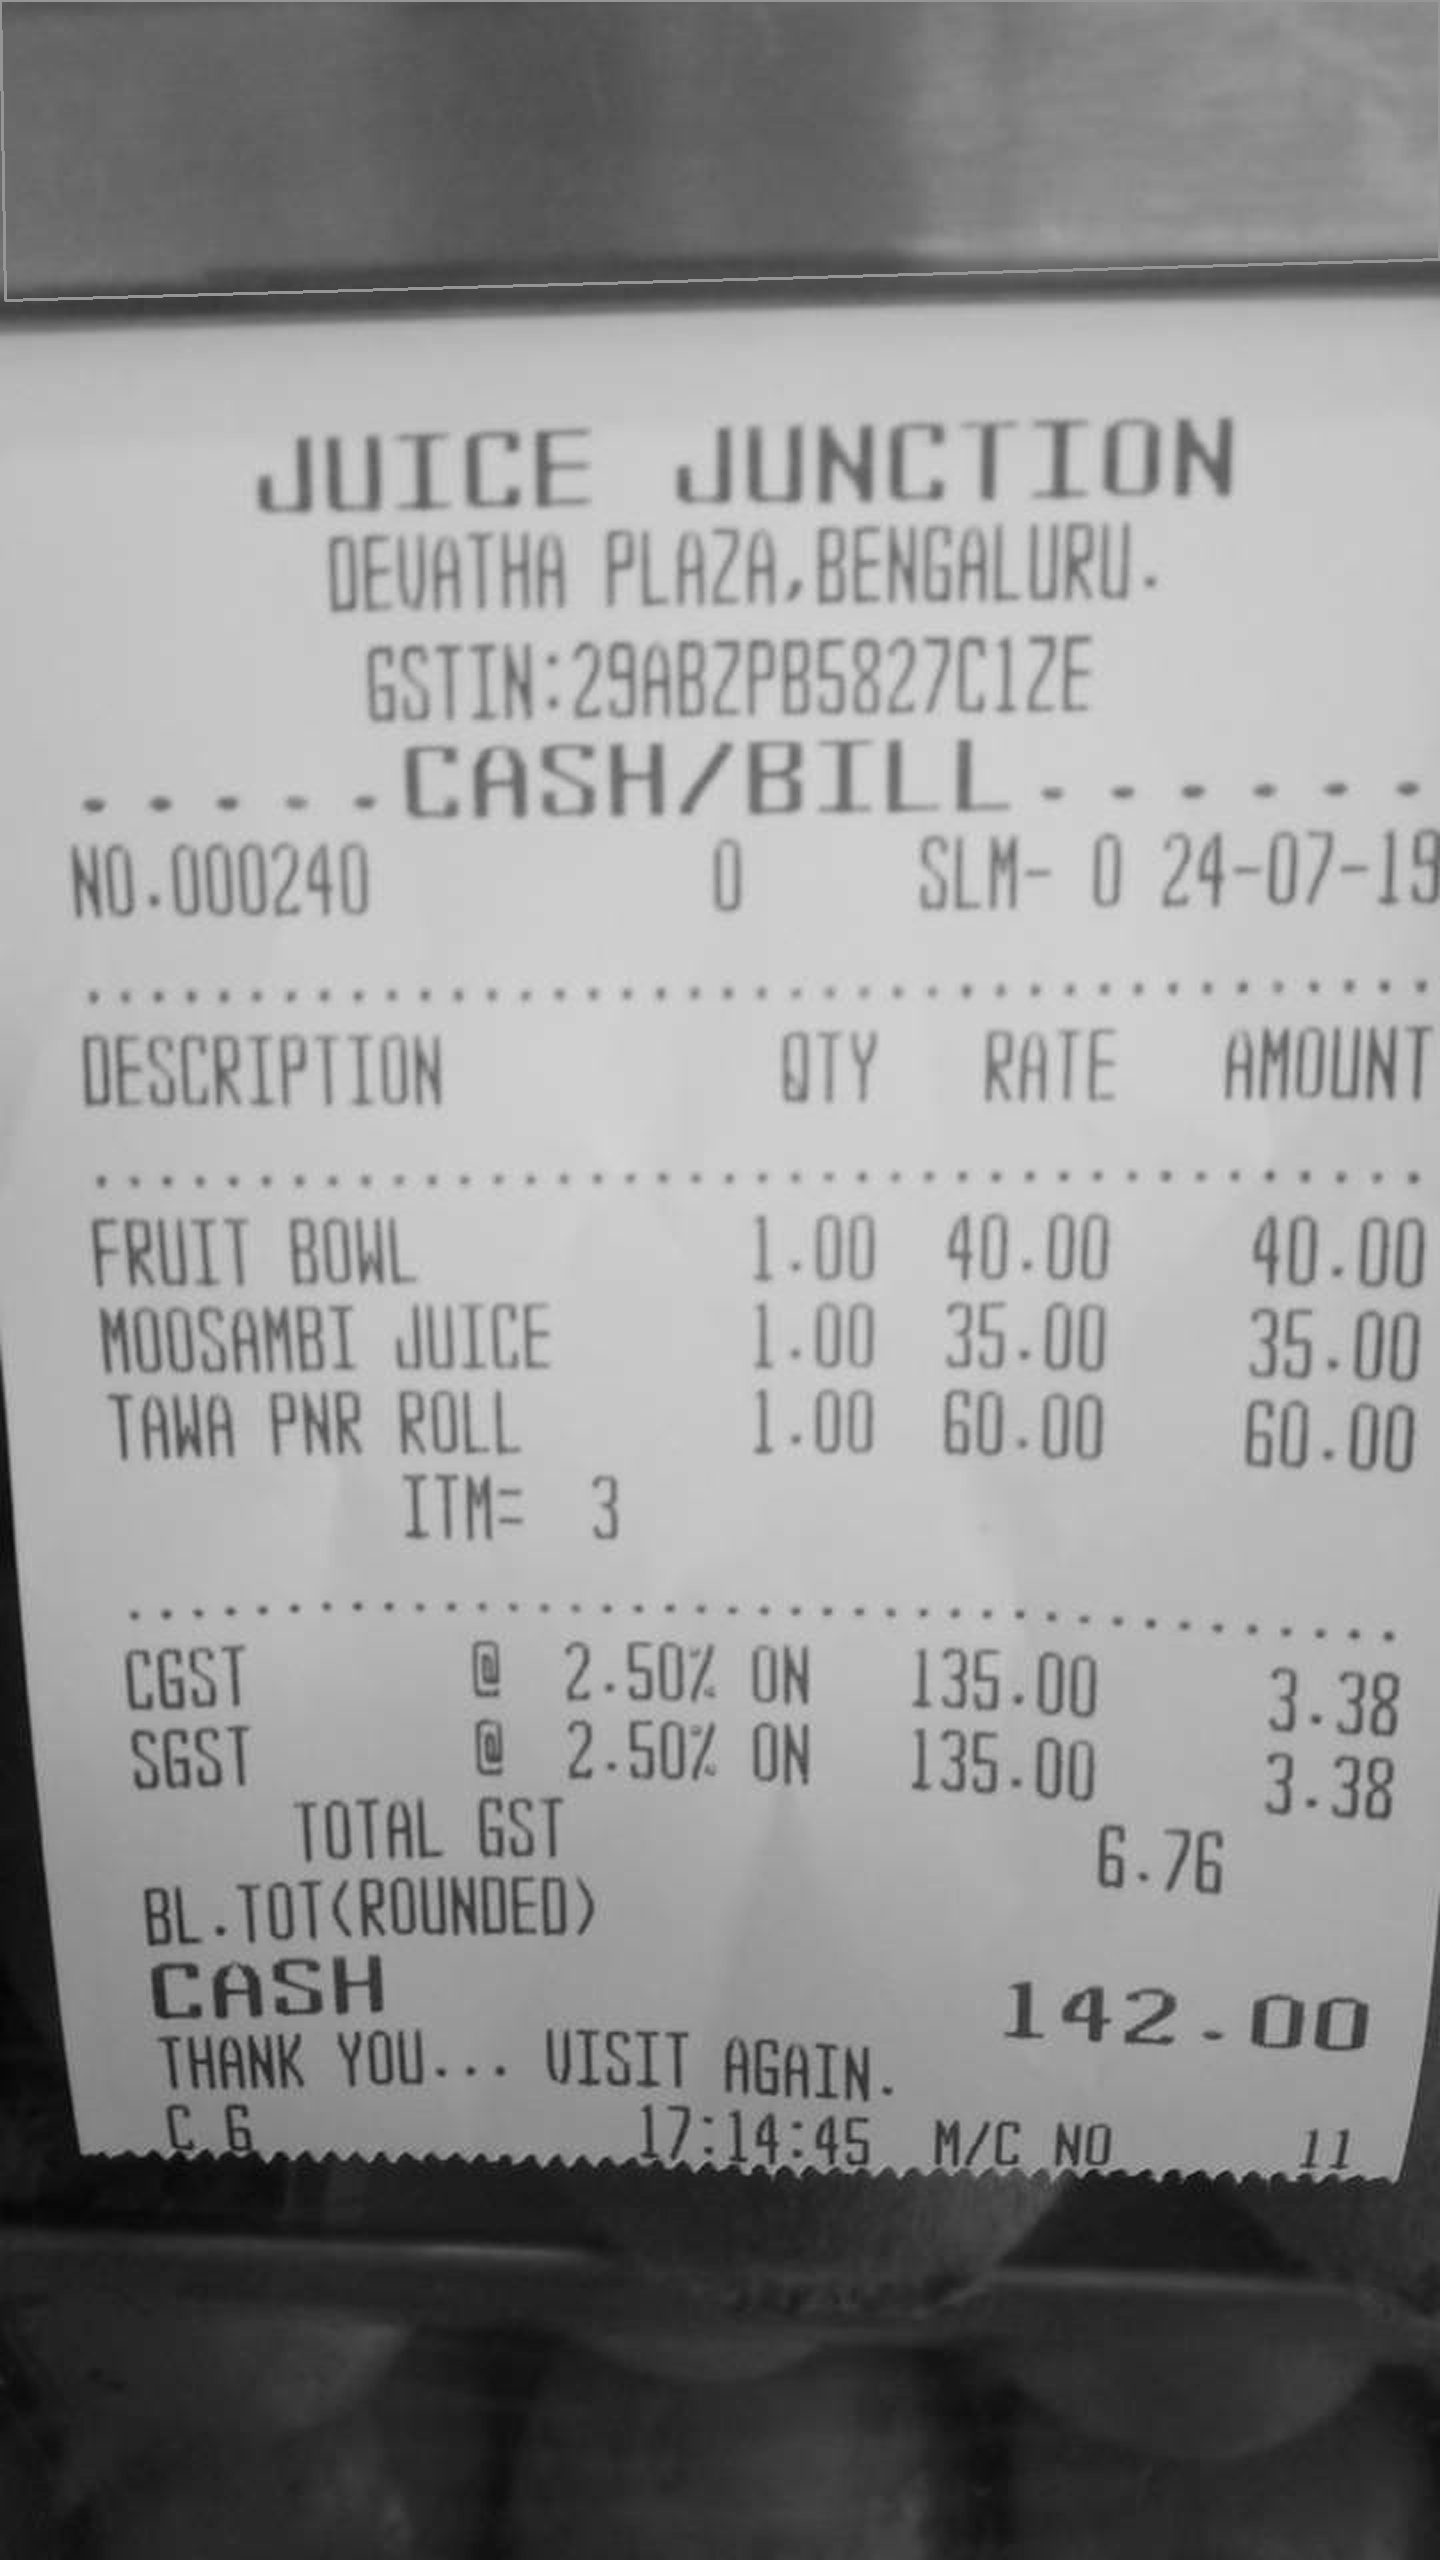

In [85]:
Image.fromarray(dst)

In [86]:
print(pt.image_to_string(Image.fromarray(dst)))


JUTCE JUNCTION
-CASH/BILI

FRUIT BOW 41) 00 40.00
MOUSAMBT JULL 5.00 35.00
TAWA PNR ROLL 1.00 60-00 §0.00
IIM= 3

CGS] @ 2.502 ON 135.00 39
SEST @ 2-50/ Oh 135.00 3.39
TOTAL GST .

aL .TOT<ROUNDED) :

CASH
THANK YOU--. VISIT agany. 7 72-20
oie 114-45 H/C No

1]


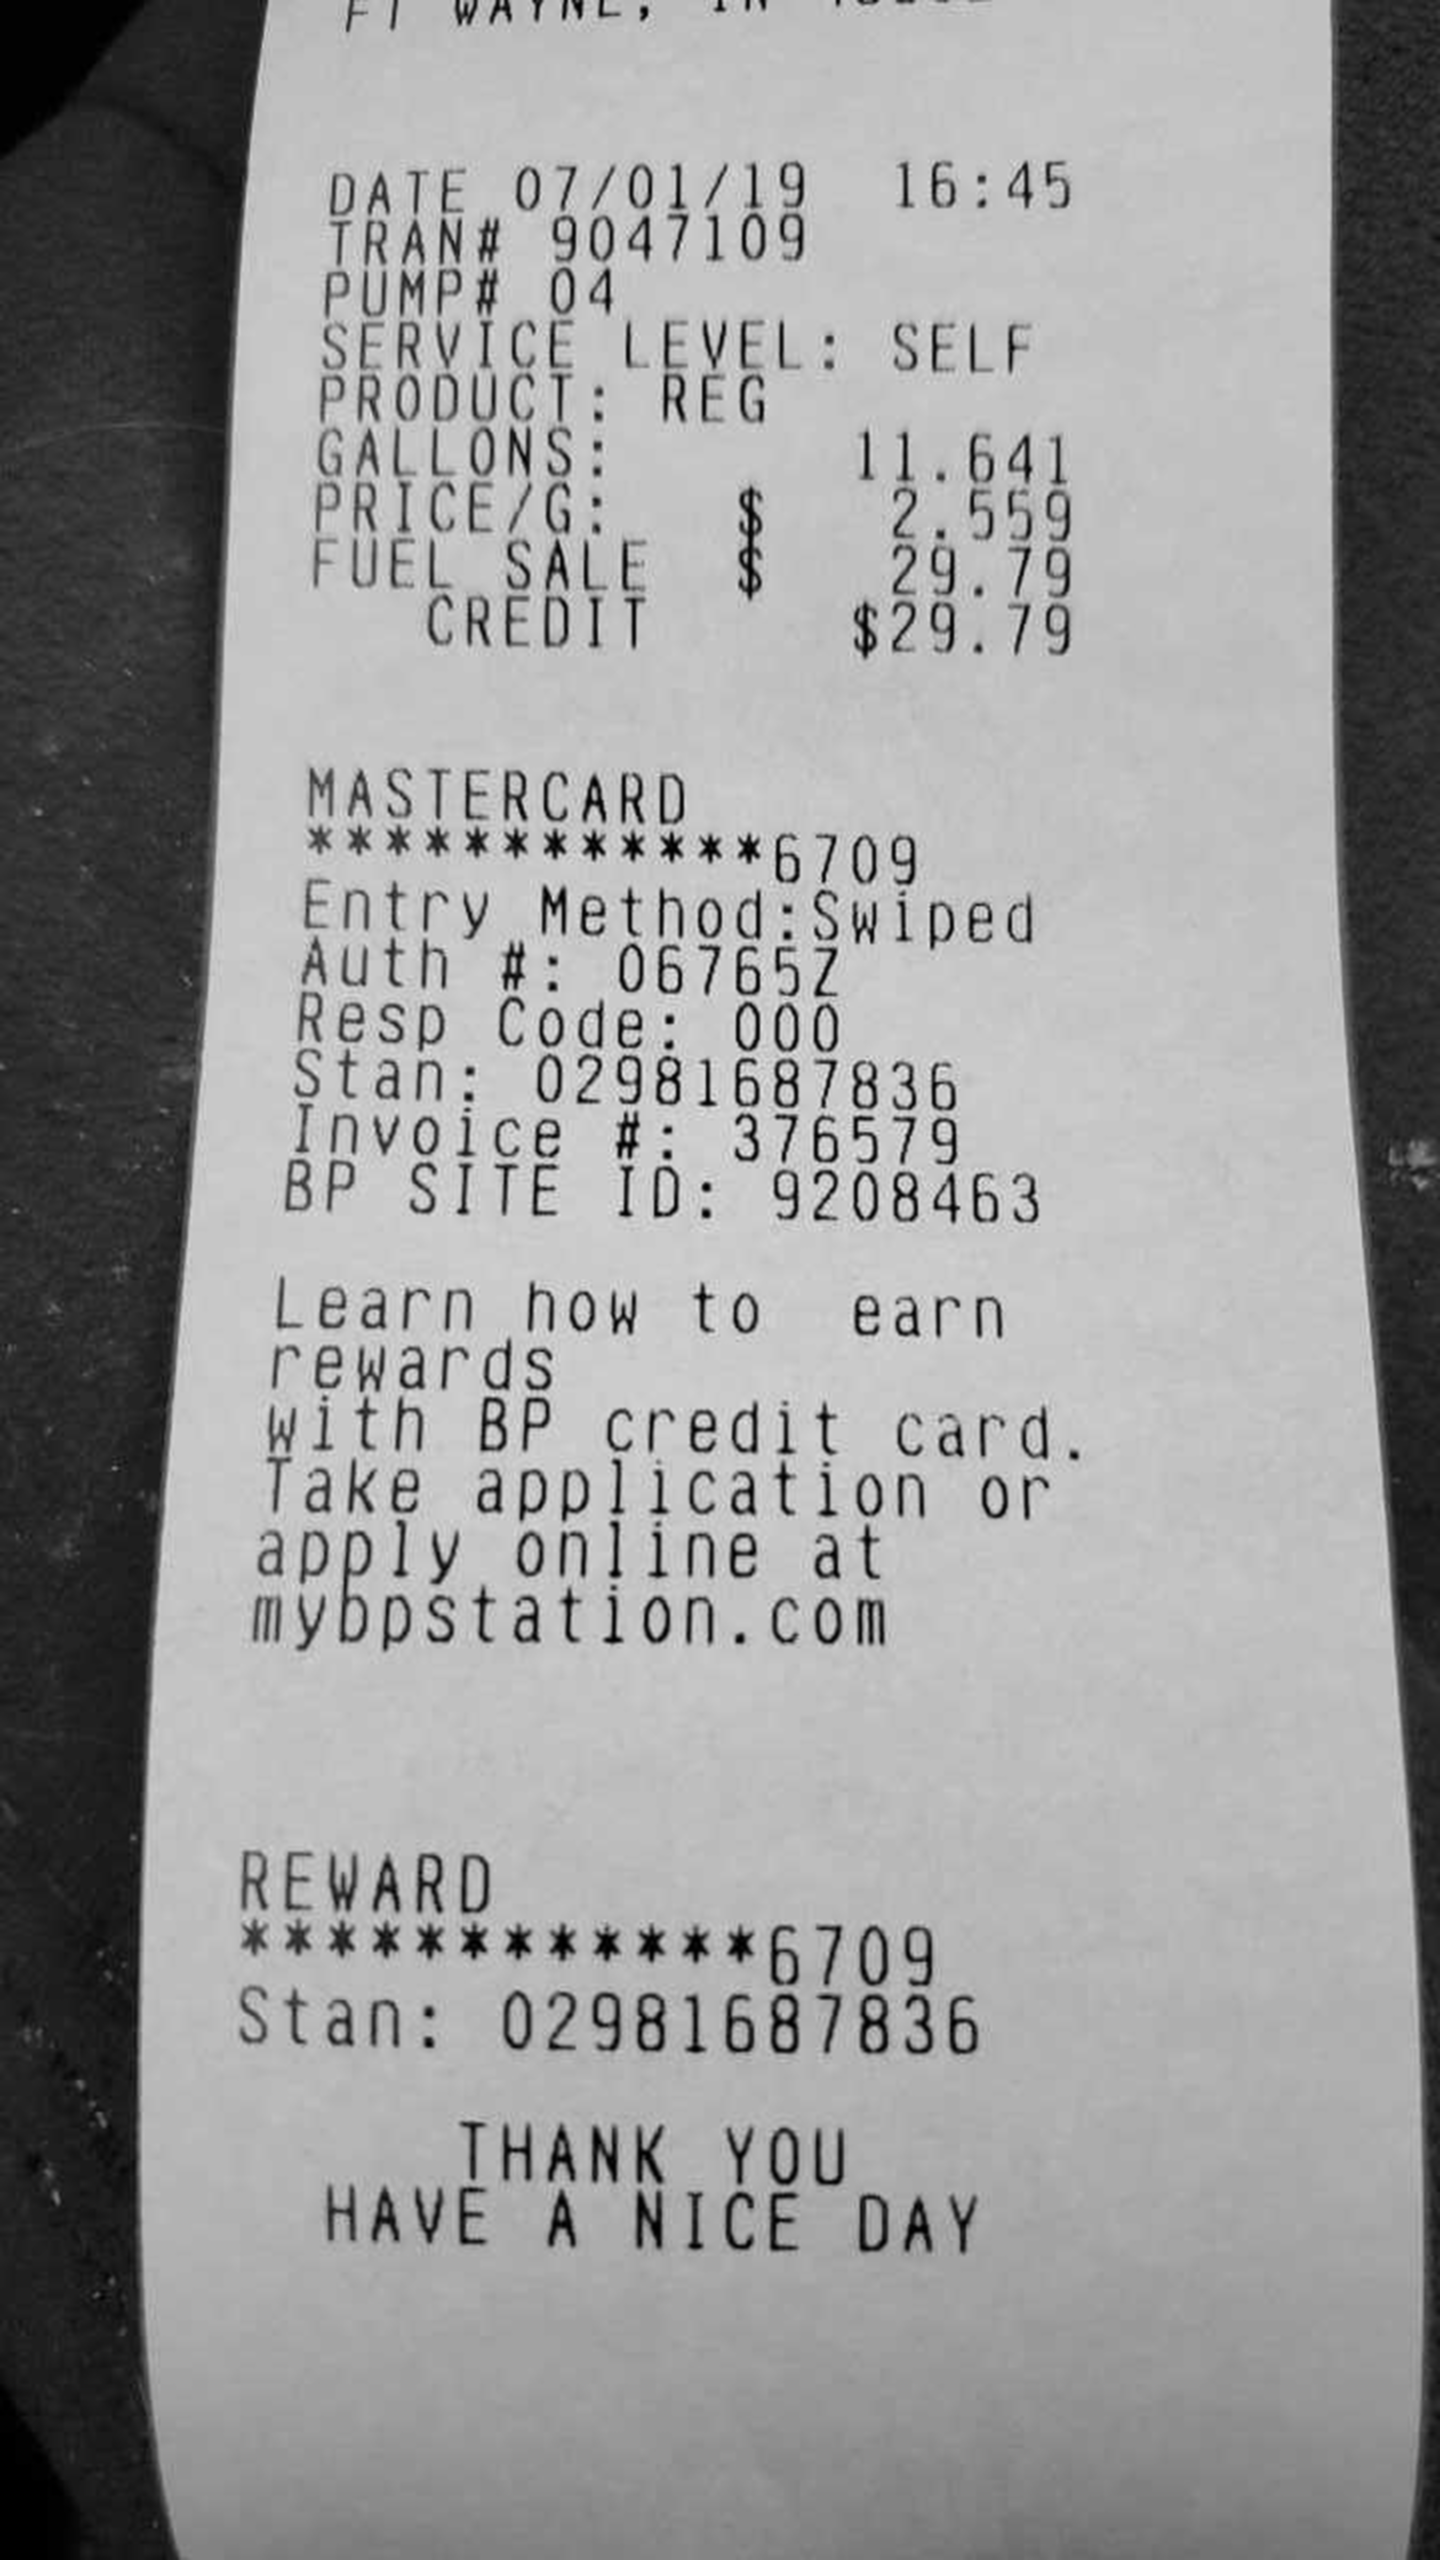

In [46]:
img_str = pt.image_to_string('images/38.jpeg', lang='eng')
print(img_str)

301 P.C.H HWY
NEWPC Rt BEACH CA
92660

SIDE_CHEVRON
eee

XXXXXXXXXXX2007
AMEX é

INVOICE E/8755208
AUTH 564282
PUNPE 9

UNLEAD REG 20,465G
PRICE/GAL $3 .899

FUEL TOTAL

   
   
   
  
   

   
      
      
  

    

  
   
 
 

CREDIT
Swiped

 
        
     

Get rewarded on
every fill-up at
Chevron with a
Techron hdvantace
card. See app
